In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!unzip -qq ./drive/My\ Drive/twitter_sentiment.zip

In [3]:
!pip install urllib3==1.25.9

!pip install transformers==2.8.0



     |████████████████████████████████| 133kB 11.8MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
     |████████████████████████████████| 573kB 13.5MB/s 
     |████████████████████████████████| 133kB 51.2MB/s 
     |████████████████████████████████| 1.1MB 50.7MB/s 
     |████████████████████████████████| 3.7MB 48.1MB/s 
     |████████████████████████████████| 890kB 48.4MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 7.1MB 48.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=554706e8daed412b9bb0f681d34b9d3e718a5b67b5884a1cc02cb25e2a07a6a6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import csv
import os
import numpy as np
import torch
import torch.nn as nn
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from collections import defaultdict


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 8, 5


In [6]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [7]:
mode='train'
reviews=[]
targets=[]
with open('./twitter_sentiment/train.csv', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                reviews.append(row['text'])

                if mode != 'test':
                    targets.append(row['sentiment_label'])


In [29]:
class sentiment_analysis(torch.utils.data.Dataset):

  def __init__(self, csv_file, mode,tokenizer):
      self.reviews = []
      self.targets = []
      self.token_lens = []
      self.mode = mode
      self.tokenizer = tokenizer
    
      with open(csv_file, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                self.reviews.append(row['text'][1:])
                tokens = tokenizer.encode(row['text'][1:], max_length=512)

                self.token_lens.append(len(tokens))

                if mode != 'test':
                    self.targets.append(int(row['sentiment_label']))

      self.reviews=pd.DataFrame(self.reviews).to_numpy()
      self.targets=np.array(self.targets)

  def tokenizer_len(self):#找出最大的tokenizer_len
      self.max_len =max(self.token_lens)
      return self.max_len

  def tolenizer_distribute(self):#畫出最大的tokenizer_len的分配

      sns.distplot(self.token_lens)
      plt.xlim([0, 256]);
      plt.xlabel('Token count');plt.show()
    
  def __len__(self):
      return len(self.reviews)
  
  def __getitem__(self, item):
      review = str(self.reviews[item])
      encoding = self.tokenizer.encode_plus(      
          review,
          add_special_tokens=True,
          max_length=max(self.token_lens),
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt')
      
      if self.mode!='test':
        target = self.targets[item]   
        return{      
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target)}
      else:
        return{      
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten()}
          

    

In [30]:
dataset_train=sentiment_analysis ('./twitter_sentiment/train.csv','train', tokenizer)
dataset_val=sentiment_analysis('./twitter_sentiment/val.csv', 'val',tokenizer)
dataset_test=sentiment_analysis('./twitter_sentiment/test.csv','test',tokenizer)

78


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


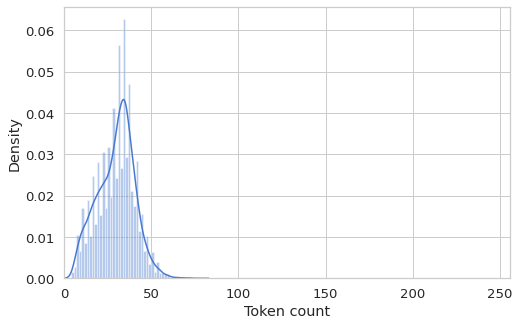

In [31]:
print(dataset_train.tokenizer_len())
dataset_train.tolenizer_distribute()

In [32]:
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [33]:
data = next(iter(train_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [34]:
data1 = next(iter(test_loader))
data1.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask'])

In [12]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [13]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [15]:
model = SentimentClassifier(3)#共有3類(正,中,負)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [47]:
def train_epoch(model,data_loader,loss_fn, optimizer,scheduler):  
 
  model = model.train()

  losses = []
  correct_predictions = 0
  total_count=0
  for d in data_loader:
    input_ids = d["input_ids"].cuda()
    attention_mask = d["attention_mask"].cuda()
    targets = d["targets"].cuda()

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask)
    

    _, preds = torch.max(outputs.data, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    total_count +=len(attention_mask)

  return correct_predictions.double() / total_count, np.mean(losses)

In [48]:
def eval_model(model, data_loader, loss_fn):
  model = model.eval()

  losses = []
  correct_predictions = 0
  total_count=0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].cuda()
      attention_mask = d["attention_mask"].cuda()
      targets = d["targets"].cuda()

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask)
     
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      # correct_predictions +=(preds==targets).sum().item()
      losses.append(loss.item())
      total_count +=len(attention_mask)

  return correct_predictions.double() / total_count, np.mean(losses)

In [56]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

#lr=3e-5,2e-5

In [57]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,train_loader,
                                      loss_fn,optimizer,scheduler)
    
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model,val_loader,loss_fn)
    
    
  print(f'Val loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:#儲存最好的模型
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.1946440669904246 accuracy 0.9398907103825137
Val loss 0.7186778297890788 accuracy 0.8360655737704918
Epoch 2/5
----------
Train loss 0.08270086339316578 accuracy 0.9774590163934426
Val loss 0.9533583722684694 accuracy 0.8203551912568307
Epoch 3/5
----------
Train loss 0.043957071258422464 accuracy 0.989656518345043
Val loss 0.9245788366736277 accuracy 0.8306010928961749
Epoch 4/5
----------
Train loss 0.022452777728142442 accuracy 0.9948282591725215
Val loss 1.0006295918770458 accuracy 0.8381147540983607
Epoch 5/5
----------
Train loss 0.014265482759373727 accuracy 0.9963895394223263
Val loss 1.0602799945551415 accuracy 0.8312841530054644


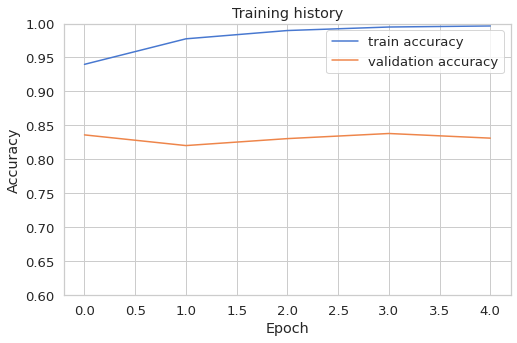

In [58]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.6, 1]);


In [59]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []

  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask)
      
      _, preds = torch.max(outputs, dim=1)

      predictions.extend(preds.to('cpu').numpy().tolist())

  return predictions

In [60]:
y_pred = get_predictions(model,test_loader)
  
y_pred

[2,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 1,
 2,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 2,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 2,
 2,
 1,
 2,
 1,
 2,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,


In [61]:
idx = 0
with open('sentiment_analysis.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['index', 'sentiment_label'])
    writer.writeheader()
    for result in y_pred:
        writer.writerow({'index':idx, 'sentiment_label':result})
        idx+=1
